# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

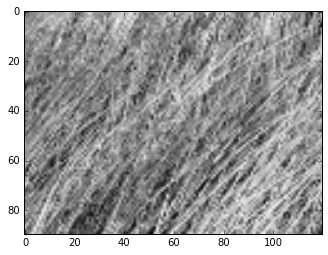

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Delete Nmis last frames:

In [4]:
Nmis = 10 # number of frames to delete

N = sample.shape[0] # count of samples
sample_missed = sample[N-Nmis:N,:]
sample = sample[0:N-Nmis,:]
np.shape(sample), np.shape(sample_missed)

((240, 10800), (10, 10800))

Initialize all the parameters and normilize given sample:

In [5]:
sample_max = sample[:,:].max()
sample_min = sample[:,:].min()
print(sample_min, sample_max)

27.0 233.0


In [6]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)
print(sample_mean)
print(sample_std)

[[-0.25926188 -0.05427777  0.31469363 ..., -0.54623963 -2.26810615
  -2.3500998 ]
 [ 0.39668727  0.02771588  0.23269999 ...,  0.56067456 -1.73514747
   1.05263643]
 [ 0.92964596  0.10970952  0.51967774 ...,  1.05263643 -0.38225234
   3.75842667]
 ..., 
 [-0.62823328  0.31469363  0.23269999 ...,  1.21662371 -1.612157
   0.23269999]
 [-0.62823328  1.13463007  0.88864914 ...,  1.46260464 -0.3002587
   0.47868092]
 [ 1.62659193  0.64266821  0.35569045 ...,  1.83157604 -1.9811284
  -1.2431856 ]]
122.323950617
24.3921346165


Define combined kernel using GPy library:

In [7]:
import GPy

#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
#kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [8]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1000)

 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\kern\src\mlp.py:58: RuntimeWarning:invalid value encountered in arcsin
 C:\Users\Maxim\Anaconda3\lib\site-packages\GPy\util\linalg.py:64: RuntimeWarning:invalid value encountered in less_equal


Extract latent X from the model:

In [9]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -1.98896055  |               |        
  [0 1]      |         2.91714692  |               |        
  [0 2]      |         0.05538913  |               |        
  [0 3]      |         1.97632547  |               |        
  [0 4]      |        -1.12691835  |               |        
  [0 5]      |         3.11511873  |               |        
  [0 6]      |        -0.69385316  |               |        
  [0 7]      |         0.19282538  |               |        
  [0 8]      |        -1.50582111  |               |        
  [0 9]      |         1.61624764  |               |        
  [ 0 10]    |         0.95948238  |               |        
  [ 0 11]    |         0.29383401  |               |        
  [ 0 12]    |         1.98306971  |               |        
  [ 0 13]    |         0.70284417  |               |        
  [ 0 14]    |        -1.85465705  |               |        
  [ 0 15]    |         1

Plot first 5 values to visualize:

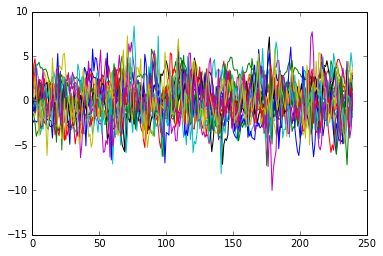

In [10]:
mp.plot(X)

Extract kernel matrix:

In [11]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 1.02707997  0.5990963   0.4644147  ...,  0.27527341  0.28480624
   0.26679458]
 [ 0.5990963   1.03798668  0.62445091 ...,  0.23709133  0.24797476
   0.24714629]
 [ 0.4644147   0.62445091  1.04960136 ...,  0.21778813  0.23100485
   0.23385451]
 ..., 
 [ 0.27527341  0.23709133  0.21778813 ...,  1.01597854  0.512899
   0.42261725]
 [ 0.28480624  0.24797476  0.23100485 ...,  0.512899    1.01615002
   0.51231621]
 [ 0.26679458  0.24714629  0.23385451 ...,  0.42261725  0.51231621
   1.01425103]]


Function to predict new artificial frame using mean prediction method:

In [12]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [13]:
N_synt = N+Nmis  # generate one frame more to compare it with dropped one
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[ 1.019545    1.15833141  1.53961271 ..., -1.67350936 -0.11746106
   1.53104634]
 [ 1.07928596  1.49443064  1.30456842 ..., -1.70353049 -1.01302356
   1.55489326]
 [ 1.15272655  1.79273223  1.24655013 ..., -1.8394366  -1.58014288
   1.7326091 ]
 ..., 
 [ 0.67609499  0.84270912 -2.10716112 ...,  1.98350261  2.91577174
   0.38467021]
 [ 1.1906438   1.68650497 -1.96577696 ...,  1.50317618  2.41072695
   3.23981165]
 [ 1.23845587  2.84016348 -1.77479189 ..., -0.70232452  1.42047535
   1.19949658]]


Plot of new X:

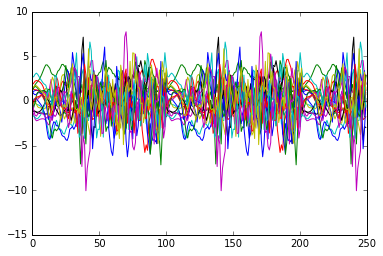

In [14]:
mp.plot(X_synt)

Now perform syntesis of new dinamic texture by mean prediction

In [15]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)

Y_synt = np.transpose(meann)
    
print(Y_synt)

[[ 0.98429358  0.93979888  0.52434252 ...,  0.97161943 -0.9611504
  -0.64036362]
 [ 0.86822533  1.08507253  0.56822498 ...,  0.98467042 -0.71824598
  -0.44077367]
 [ 0.7289513   1.12900208  0.56664128 ...,  1.06509014 -0.63252781
  -0.34672686]
 ..., 
 [ 0.31446613  0.39616759 -0.58597966 ...,  1.50160349  1.79022099
   1.09224736]
 [ 0.39631819  0.31461719  0.2332923  ..., -1.5309604  -0.8754211
  -1.40858664]
 [ 0.0273881   0.27370061  0.68359035 ...,  0.76652526 -0.66879521
  -0.99709683]]


Display first frame:

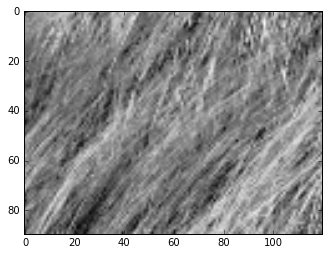

In [16]:
show_frame(Y_synt[0,:])

Denormalization:

In [17]:
Y_synt_denorm = sample_std * Y_synt + sample_mean
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)
print(sample_min,sample_max)

30.9999990328 232.999996639
27.0 233.0


In [18]:
sample_mean2 = np.mean(Y_synt_denorm)
sample_std2 = np.std(Y_synt_denorm)

print(sample_mean,sample_std)
print(sample_mean2,sample_std2)

122.323950617 24.3921346165
121.658467942 22.4384864632


Compare missing and predicted frames:

In [19]:
sample_missed_pred = Y_synt_denorm[N:N+Nmis,:]

sample_missed_const = np.zeros((Nmis,D))
for i in range(Nmis):
    sample_missed_const[i,:] = Y_synt_denorm[N-1,:]

Mean Sqare Error:

In [20]:
MSE = (1/D)*((sample_missed_pred - sample_missed)**2).sum(1)
MSE_const = (1/D)*((sample_missed_const - sample_missed)**2).sum(1)

926.947851704
849.661941841 991.614671621


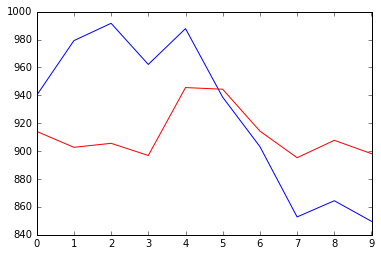

In [21]:
print(np.mean(MSE))
print(MSE.min(), MSE.max())
mp.plot(MSE,'b')
mp.plot(MSE_const,'r')

Absolute difference:

In [22]:
dif = np.mean(abs(sample_missed_pred - sample_missed),1)
print(np.mean(dif))
print(dif.min(), dif.max())

23.8107735747
22.8481726895 24.5771173775


Finally, save synthesized video:

In [23]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\out_misframes.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!
